action probabilites: tensor([[0.2479, 0.2553, 0.2686, 0.2282]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2462, 0.2452, 0.2655, 0.2431]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2462, 0.2452, 0.2655, 0.2431]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2462, 0.2452, 0.2655, 0.2431]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2479, 0.2553, 0.2686, 0.2282]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2072, 0.2625, 0.2930, 0.2374]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2072, 0.2625, 0.2930, 0.2374]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2042, 0.2529, 0.2971, 0.2458]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2072, 0.2625, 0.2930, 0.2374]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2072, 0.2625, 0.2930, 0.2374]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2042, 0.2529, 0.2971, 0.2458]], grad_fn=<Softmax

/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


action probabilites: tensor([[0.2018, 0.2595, 0.2995, 0.2393]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.1811, 0.2476, 0.3419, 0.2293]], grad_fn=<SoftmaxBackward0>)
Episode: 6, Total Timesteps: 107, Episode Reward: -107
Total reward obtained for episode 6: -107
action probabilites: tensor([[0.2448, 0.2561, 0.2690, 0.2301]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2504, 0.2453, 0.2647, 0.2396]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2423, 0.2437, 0.2688, 0.2451]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2423, 0.2437, 0.2688, 0.2451]], grad_fn=<SoftmaxBackward0>)
Episode: 7, Total Timesteps: 111, Episode Reward: -103
Total reward obtained for episode 7: -103
action probabilites: tensor([[0.2448, 0.2561, 0.2690, 0.2301]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2448, 0.2561, 0.2690, 0.2301]], grad_fn=<SoftmaxBackward0>)
action probabilites: tensor([[0.2448, 0.2561, 0.2690, 0.2301]], grad_f

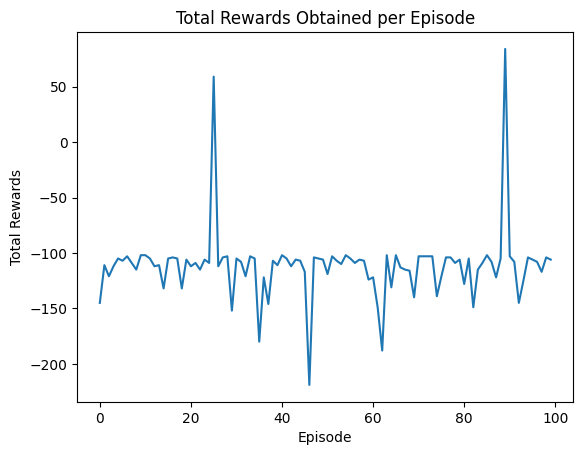

Success rate of episodes: 0.02


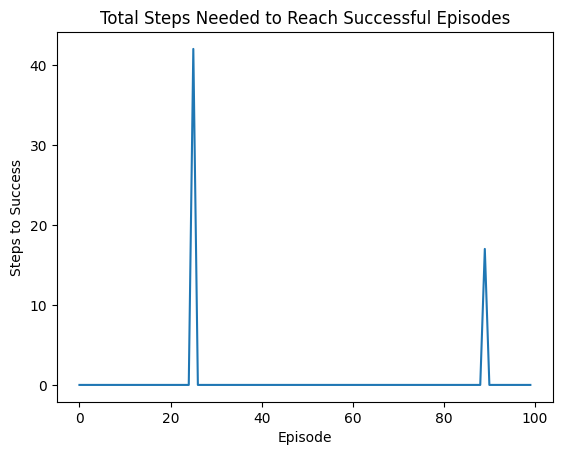

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from environment import Env
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Define hyperparameters
gamma = 0.99
eps_clip = 0.2
learning_rate = 0.0005
update_timestep = 20

# Create environment
env = Env()
state_dim = len(env.reset())
action_dim = len(env.action_space)

# Actor-critic network architecture
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.actor = nn.Linear(64, action_dim)
        self.critic = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

# Proximal Policy Optimization (PPO) algorithm
class PPO:
    def __init__(self):
        self.policy = ActorCritic()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        logits, _ = self.policy(state)
        action_probs = torch.softmax(logits, dim=-1)
        action = torch.multinomial(action_probs, 1)
        # print(f"action probabilites: {action_probs}")
        return action.item()

    def train(self, states, actions, advantages, returns):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        advantages = torch.FloatTensor(advantages).unsqueeze(1)
        returns = torch.FloatTensor(returns)

        unique_actions, unique_indices = torch.unique(actions, return_inverse=True)

        logits, values = self.policy(states)
        values = values.squeeze()

        action_probs = torch.softmax(logits, dim=-1)
        action_masks = torch.zeros_like(action_probs).scatter_(1, unique_actions.unsqueeze(1), 1)
        old_action_probs = torch.sum(action_probs * action_masks[unique_indices.unsqueeze(1)], dim=1)
        ratios = torch.exp(torch.log(old_action_probs + 1e-10) - torch.log(action_probs + 1e-10))

        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - eps_clip, 1 + eps_clip) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        critic_loss = nn.MSELoss()(returns, values)

        loss = actor_loss + 0.5 * critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

class Analyzer:
    @staticmethod
    def plot_total_rewards(episode_rewards):
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Rewards')
        plt.title('Total Rewards Obtained per Episode')
        plt.show()

    @staticmethod
    def calculate_success_rate(success_count, n_episodes):
        return success_count / n_episodes

    @staticmethod
    def plot_steps_to_success(success_steps):
        plt.plot(success_steps)
        plt.xlabel('Episode')
        plt.ylabel('Steps to Success')
        plt.title('Total Steps Needed to Reach Successful Episodes')
        plt.show()

# Initialize PPO agent
ppo_agent = PPO()

# Main training loop
total_timesteps = 0
episode_rewards = []
success_count = 0
success_steps = []

for episode in range(100):  # Run 100 episodes
    total_rewards = 0
    episode_steps = 0
    max_steps = 1000

    states, actions, rewards, dones, next_states = [], [], [], [], []
    episode_reward = 0
    state = env.reset()

    while episode_steps < max_steps :
        # env.render()
        action = ppo_agent.select_action(state)
        next_state, reward, done = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        next_states.append(next_state)

        episode_reward += reward
        state = next_state
        episode_steps += 1

        total_timesteps += 1

        if done:
            total_rewards += episode_reward
            if episode_reward >= 0:  # Considered successful if the total reward is 200 or more
                success_count += 1
                success_steps.append(episode_steps)
            else:
                success_steps.append(0)
            break

        if total_timesteps % update_timestep == 0:
            _, next_value = ppo_agent.policy(torch.FloatTensor(next_states))
            returns, advantages = [], []
            discounted_sum = 0
            for i in range(len(rewards) - 1, -1, -1):
                discounted_sum = rewards[i] + gamma * discounted_sum * (1 - dones[i])
                advantage = discounted_sum - next_value[i].item()
                advantages.insert(0, advantage)
                returns.insert(0, discounted_sum)

            ppo_agent.train(states, actions, advantages, returns)

    episode_rewards.append(total_rewards)
    print(f"Episode: {episode + 1}, Total Timesteps: {total_timesteps}, Episode Reward: {episode_reward}")

    # Print total reward obtained for each episode
    print(f"Total reward obtained for episode {episode + 1}: {total_rewards}")

# Call Analyzer functions to generate outputs
Analyzer.plot_total_rewards(episode_rewards)
success_rate = Analyzer.calculate_success_rate(success_count, 100)
print("Success rate of episodes:", success_rate)
if success_count > 0:
    Analyzer.plot_steps_to_success(success_steps)
else:
    print("No successful episodes.")
